# RNN with LSTM for japanese character classification

In [14]:
import time
import math
import random

import os
import glob
import csv

import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from google.colab import drive, files
drive.mount("/content/gdrive")
%cd gdrive/My Drive/Colab\ Notebooks/

## Prepating the data

In [2]:
def load_data(subfolder="train"):
    
    """
    load_data() -> Dictionary, List
    
    Returns a dictionary filled with characters as keys and a list with file-paths as values.
        Returns a list with all found characters.
    
    Keywords:
        subfolder - "train" oder "test". Default: "train"
    """
    
    # initialize dictionary and lists
    character_files = {}
    all_characters = []
    
    # search files in path
    def find_files(path):
        return glob.glob(path)
    
    for filename in find_files("data/"+subfolder+"/*csv"):
        # get character from filename
        character = os.path.splitext(os.path.basename(filename))[0][0]
        
        # collect all characters
        if (character in all_characters) == False:
            all_characters.append(character)
        
        # expand lists in dictionary for character (key)
        character_files.setdefault(character, []).append(filename)

    # sort list
    all_characters.sort()
    
    return character_files, all_characters
        
    
def file_to_tensor(file, batch=1, input_size=3):
    
    """
    file_to_tensor(file, batch=1, input_size=3) -> Tensor
    
    Returns a tensor of shape (seq_len, batch, input_size).
    
    Keywords:
        file - e.g. "data/train\\a__02621.csv"
        batch - total number of training examples present in a single batch
        input_size - the number of expected features in the input x
    """
    
    # initialize lists for acceleration data
    x_acc = []
    y_acc = []
    z_acc = []

    with open(file, newline="") as csvdatei:
        # add rows as string to list
        csv_reader_object = csv.reader(csvdatei, delimiter=",")

        # ground truth and identifier
        gt, idf = csvdatei.name.split("__")
        # ground truth = last character
        gt = gt[-1]
        # identifier without ".csv" as integer
        idf = int(idf[0:-4])
        
        # append list with acceleration data
        for row in csv_reader_object:
            cal, x, y, z = row[0].split(";")
            # cal = 1 --> calibration completed
            if cal == "1":
                x_acc.append(float(x))
                y_acc.append(float(y))
                z_acc.append(float(z))
                
        # get sequence length
        seq_len = len(x_acc)
        
        # create empty tensor
        tensor = torch.zeros(seq_len, batch, input_size, dtype=torch.float32)
        
        # fill tensor
        for i in range(seq_len):
            tensor[i][0][0] = x_acc[i]
            tensor[i][0][1] = y_acc[i]
            tensor[i][0][2] = z_acc[i]
        
    return tensor


def character_to_tensor(all_characters, character):
    
    """
    character_to_tensor(all_characters, character) -> Tensor
    
    Returns a one-hot encoded tensor of shape <1 x n_characters>.
        Tensor represents given character.
        
    Keywords:
        all_characters - list with all characters
        character - character that will be one-hot encoded
    """
    
    # number of all characters
    n_characters = len(all_characters)
    # create empty tensor
    tensor = torch.zeros(1, n_characters)
    # label of character in tensor
    tensor[0][all_characters.index(character)] = 1
    
    return tensor
    
    
def random_training_example(character_files, all_characters):
    
    """
    random_training_example(character_files, all_characters) -> String, String, Tensor, Tensor
    
    Returns a random training example. Character and file as string,
        character-label and whole file as tensor.
        
    Keywords:
        character_files - dictionary filled with characters as keys and
            a list with file-paths as values
        all_characters - list with all characters     
    """
    
    # get random value from list
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
        
    # random character
    character = random_choice(all_characters)
    # random file from selected character
    file = random_choice(character_files[character])
    # label as tensor; dtype = 64-bit integer
    character_tensor = torch.tensor([all_characters.index(character)], dtype=torch.long)
    # transformation file to tensor
    file_tensor = file_to_tensor(file)
    
    return character, file, character_tensor, file_tensor

## Define network structure

In [3]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_layers, n_characters):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=False)
        # -> x of shape (seq_len, batch, hidden_size)
        self.fc = nn.Linear(hidden_size, n_characters)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # initial hidden- & cell-state
        h0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)
        
        # output of shape (seq_len, batch, n_directions * hidden_size)
        out, _ = self.lstm(x, (h0,c0))
        
        # only last Time-Step
        out = out[-1, :, :]
        
        out = self.fc(out)
        out = self.softmax(out)

        return out

## Define helper functions for neural network's training

In [5]:
def train(file_tensor, character_tensor):
    output = model(file_tensor)
    loss = criterion(output, character_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

## Defining hyperparameters of neural network's training

In [6]:
# load train dataset
character_files, all_characters = load_data(subfolder="train")

# hyper parameters
input_size = 3 # features: x_acc, y_acc, z_acc
n_characters = len(all_characters) # output_size
hidden_size = 128
n_layers = 1

learning_rate = 0.005

## Start training loop

In [7]:
# initialize neural network   
model = RNN(input_size, hidden_size, n_layers, n_characters).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []

print_every = 5000
plot_every = 1000
n_iters = 50000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iters + 1):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor.to(device), character_tensor.to(device))
    current_loss += loss
    
    # print iter number, loss, name and guess
    if i % print_every == 0:
        guess = character_from_output(output)
        correct = '✓' if guess == character else '✗ (%s)' % character
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, file, guess, correct))

    # add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 10% (1m 21s) 0.1003 data/train/e__11863.csv / e ✓
10000 20% (2m 46s) 0.4983 data/train/a__77402.csv / a ✓
15000 30% (4m 6s) 0.8031 data/train/o__24182.csv / o ✓
20000 40% (5m 28s) 0.2918 data/train/u__96553.csv / u ✓
25000 50% (6m 50s) 0.0065 data/train/e__54428.csv / e ✓
30000 60% (8m 12s) 0.0174 data/train/u__71715.csv / u ✓
35000 70% (9m 32s) 0.0049 data/train/i__29449.csv / i ✓
40000 80% (10m 53s) 0.0142 data/train/e__49604.csv / e ✓
45000 90% (12m 14s) 0.0016 data/train/o__30767.csv / o ✓
50000 100% (13m 37s) 0.0009 data/train/a__55117.csv / a ✓


## Plot LOSS-function

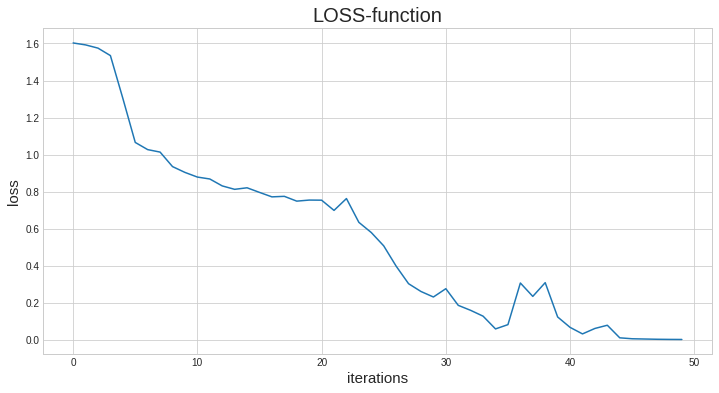

In [8]:
# create figure
mpl.style.use("seaborn-whitegrid")
plt.figure(figsize=(12,6))
# create plot
plt.plot(all_losses)
# title and labels
plt.title("LOSS-function", fontsize=20)
plt.xlabel("iterations", fontsize=15)
plt.ylabel("loss", fontsize=15)
# show plot
plt.show()

## Save model

In [11]:
FILE = "main_lstm.pth"
torch.save(model.state_dict(), FILE)

## Load model

In [8]:
FILE = "main_lstm.pth"
loaded_model = RNN(input_size, hidden_size, n_layers, n_characters).to(device)
loaded_model.load_state_dict(torch.load(FILE, map_location=device))
loaded_model.eval()

RNN(
  (lstm): LSTM(3, 128)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Determine accuracy

characters in test data:  ['a', 'e', 'i', 'o', 'u']
data/test\a__88470.csv a ✓
data/test\a__94789.csv a ✓
data/test\a__96486.csv a ✓
data/test\a__97545.csv a ✓
data/test\a__98539.csv a ✓
data/test\e__70433.csv e ✓
data/test\e__76682.csv e ✓
data/test\e__82254.csv e ✓
data/test\e__83191.csv e ✓
data/test\e__84585.csv e ✓
data/test\i__75461.csv i ✓
data/test\i__81833.csv i ✓
data/test\i__88644.csv i ✓
data/test\i__89095.csv i ✓
data/test\i__91889.csv i ✓
data/test\o__54903.csv o ✓
data/test\o__63253.csv o ✓
data/test\o__67824.csv o ✓
data/test\o__72419.csv o ✓
data/test\o__76748.csv o ✓
data/test\u__81848.csv u ✓
data/test\u__82120.csv u ✓
data/test\u__83897.csv u ✓
data/test\u__85976.csv u ✓
data/test\u__88458.csv u ✓
data/test\u__93521.csv u ✓

accuracy = 100.00 %



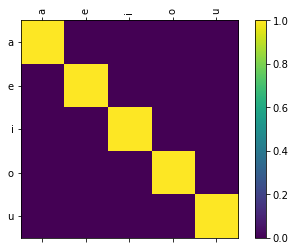

In [21]:
# load test dataset
character_files, all_characters = load_data(subfolder="test")
print("characters in test data: ", all_characters)

# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_characters, n_characters)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for character in all_characters:
        # all files from one character
        for file in character_files[character]:
            file_tensor = file_to_tensor(file).to(device)
            # get output
            output = loaded_model(file_tensor).to(device)
            # get character from output
            guess = character_from_output(output)
            n_samples += 1
            if guess == character:
                n_correct += 1
                correct = "✓"
            else:
                correct = "✗ (%s)" % character
            confusion[all_characters.index(character)][all_characters.index(guess)] += 1
            
            print(file, guess, correct)

    # normalize by dividing every row by its sum
    for i in range(n_characters):
        confusion[i] = confusion[i] / confusion[i].sum()

acc = 100.0 * n_correct / n_samples
print(f"\naccuracy = {acc:.2f} %\n")

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# set up axes
ax.set_xticklabels([''] + all_characters, rotation=90)
ax.set_yticklabels([''] + all_characters)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()